# <p style="text-align: center;">Assignment 2 - FuTSA</p>

In [227]:
## Importing Libraries
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
import seaborn as sns

%matplotlib inline

#### Read the machine_temp_failure_missing.csv dataset into a Pandas DataFrame, must use PathLib. Inspect the dataset, and look for missing values if there are any. Find statistics such as mean, max, min. Rename the value column to temperature. 

In [199]:
## Storing all paths in a list
path = []
p = Path('.')

for f in p.glob('*'):
    path.append(f)

In [94]:
# df = df.rename({"value":"temperature"},axis=1)
def rename(df_):
    df_ = df_.rename({"value":"temperature"},axis=1)
    
    return df_

In [257]:
## Loading Data and Renaming column
df = pd.read_csv(path[2], parse_dates=['timestamp'], index_col='timestamp')
df_W = pd.read_csv(path[3], parse_dates=['timestamp'], index_col='timestamp')
df_W = rename(df_W)

In [149]:
df.head()

,temperature
timestamp,
2013-02-12 21:15:00,73.967322
2013-02-12 21:20:00,74.935882
2013-02-12 21:25:00,76.124162
2013-02-12 21:30:00,78.140707
2013-02-12 21:35:00,79.329836


In [87]:
df.isnull().sum()

value    1285
dtype: int64

In [88]:
df.describe()

,value
count,21410.000000
mean,85.968188
std,13.553070
min,2.084721
25%,83.082867
50%,89.251290
75%,93.910748
max,108.510543


In [95]:
df = rename(df)

#### Create a new feature delta_temperature which would be temp[i+1] - temp[i] where i is in range(Index). The feature represents the difference between consecutive temperature values. 

In [225]:
df['delta_temperature'] = df['temperature'] - df['temperature'].shift(1)
df.head()

,temperature,delta_temperature
timestamp,,
2013-02-12 21:15:00,73.967322,NaN
2013-02-12 21:20:00,74.935882,0.968560
2013-02-12 21:25:00,76.124162,1.188280
2013-02-12 21:30:00,78.140707,2.016546
2013-02-12 21:35:00,79.329836,1.189128


#### Generate two separate plots for temperature and delta_temperature using  matplotlib.


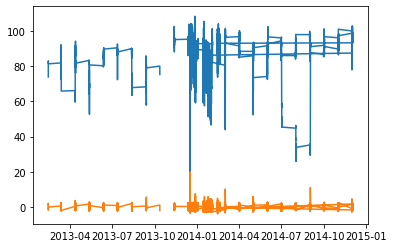

In [97]:
plt.plot(df)
# Temperature plot in Blue Color
# Delta Temperature plot in Orange Color

#### Generate a plot in which temperature values greater than 70.00 are marked as red, and those below 70.00 are marked as blue. 


In [98]:
mask = ma.masked_less(df['temperature'].to_numpy(), 70.00)

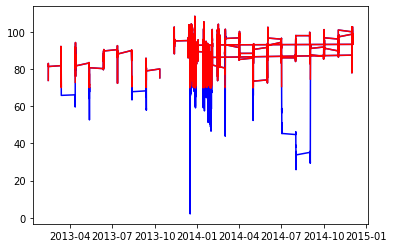

In [99]:
plt.plot(df.index,df['temperature'].to_numpy(),'b')
plt.plot(df.index,mask,'r')
plt.show()
# Red represents the data points > 70 and blue vice vera

#### Write three functions read_datasets(), plot_dfs(), rmse_score() for these datasets (as discussed in 1_4 notebook).

In [11]:
def read_dataset(address, date_col=None):
    df = pd.read_csv(address, 
                     index_col=date_col, 
                     parse_dates=[date_col])
    return df

In [58]:
def plot_dfs(df1, df2, col, title=None, xlabel=None, ylabel=None):
    df_missing = df2.rename(columns={col: 'temperature'})
    
    columns = df_missing.loc[:, 'temperature':].columns.tolist()
    subplots_size = len(columns)
    
    # subplots_size = df2.shape[1]
    fig, ax = plt.subplots(subplots_size+1, 1, sharex=True)
    plt.subplots_adjust(hspace=0.25)
    fig.suptitle = title 
    
    df1[col].plot(ax=ax[0], figsize=(10, 16))
    ax[0].set_title('Original Dataset')
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel(ylabel)    
    
    for i, colname in enumerate(columns):
        df_missing[colname].plot(ax=ax[i+1])
        ax[i+1].set_title(colname)

    plt.show()

In [162]:
def rmse(df_true,df_pred):
    score = mean_squared_error(df_true,df_pred)
    return score

#### Perform univariate imputation on temperature and  using Pandas (mean, ffill, bfill) and Scikit-Learn (SimpleImputer), and interpolation. Compare the RMSE score for each imputation with machine_temp_failure_original.csv  and find the method with the least RMSE score.


In [154]:
## Imputation Methods
df1 = df.fillna(method='ffill')
df2 = df.fillna(method='bfill')
df3 = df.fillna(df.mean())

In [161]:
df_temp = pd.read_csv(path[2])
df_temp = rename(df_temp)
vals = df_temp['temperature'].values.reshape(-1,1)
df_temp['temperature'] = SimpleImputer(strategy='mean').fit_transform(vals)
df_temp['timestamp'] = pd.to_datetime(df_temp['timestamp'])
df_temp = df_temp.set_index('timestamp')

In [163]:
print("RMSE score for ffill:",rmse(df_W['temperature'],df1['temperature']))
print("RMSE score for bfill:",rmse(df_W['temperature'],df2['temperature']))
print("RMSE score for Mean based imputation:",rmse(df_W['temperature'],df3['temperature']))
print("RMSE score for SimpleImputer:",rmse(df_W['temperature'],df_temp['temperature']))
print("\n")
print("Clearly ffill is the best stratergy here hence we will move ahead with the same")

RMSE score for ffill: 6.220014314326999
RMSE score for bfill: 34.49363916986555
RMSE score for Mean based imputation: 15.693771410936213
RMSE score for SimpleImputer: 15.693771410936213


Clearly ffill is the best stratergy here hence we will move ahead with the same


#### Now the dataset with the least RMSE score  to check the frequency of data and resample the dataset to an hourly frequency. 

In [143]:
df1.value_counts()

temperature
94.204409      638
75.347879      316
82.751587      142
102.860002     114
95.108901       13
              ... 
85.774283        1
85.774036        1
85.773675        1
85.771952        1
108.510543       1
Length: 21410, dtype: int64

(array([8.0000e+00, 6.0000e+00, 2.9400e+02, 1.5300e+02, 4.8000e+02,
        1.0200e+03, 1.7420e+03, 5.3230e+03, 1.0638e+04, 3.0310e+03]),
 array([  2.08472121,  12.72730337,  23.36988552,  34.01246768,
         44.65504984,  55.297632  ,  65.94021416,  76.58279632,
         87.22537848,  97.86796064, 108.5105428 ]),
 <BarContainer object of 10 artists>)

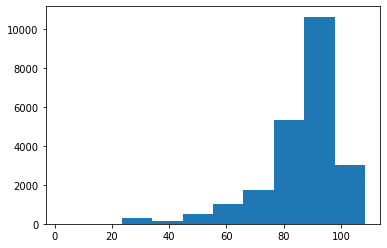

In [142]:
## frequency distribution of data
plt.hist(df1)

In [256]:
df1 = df1.resample('H').mean().ffill()
df1.head()

,temperature,zscores
timestamp,,
2013-02-12 21:00:00,78.011596,-0.607432
2013-02-12 22:00:00,80.598012,-0.413888
2013-02-12 23:00:00,81.625018,-0.337036
2013-02-13 00:00:00,81.625018,-0.337036
2013-02-13 01:00:00,81.625018,-0.337036


#### Draw box plot, boxen plot, lag plot and write your conclusions about outliers (in your own language). Define iqr_outliers() function for this data, and find the outliers. Compute z-score and plot z-score as discussed in the notebooks. 

<AxesSubplot:xlabel='timestamp', ylabel='temperature'>

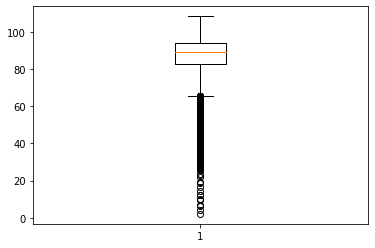

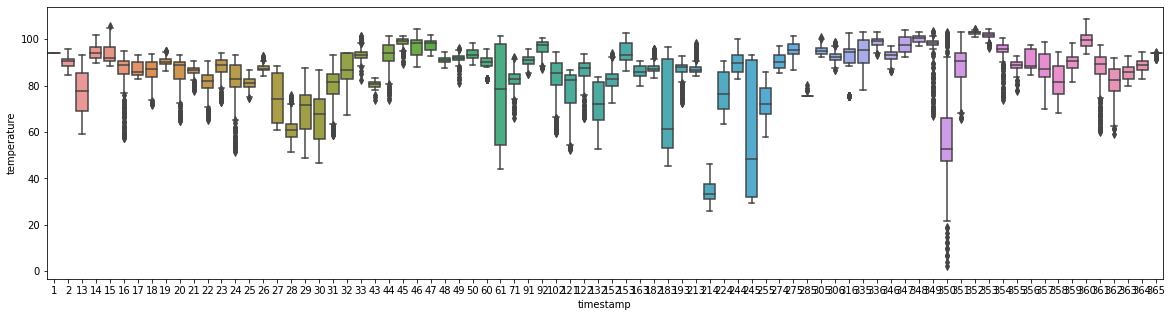

In [175]:
## Box and Boxen Plots
plt.boxplot(df1)
fig, ax = plt.subplots(figsize=(20,5))
sns.boxplot(x = df1.index.dayofyear, 
                y = df1['temperature'], 
                ax = ax)

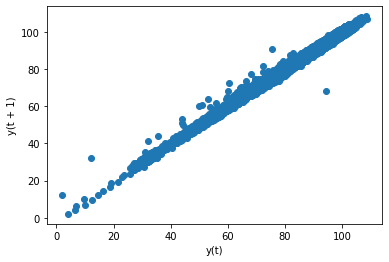

In [180]:
## Lag Plot
pd.plotting.lag_plot(df1['temperature'],lag=1)
plt.show()

In [187]:
df1['zscores'] = (df1 - df1.mean())/df1.std()

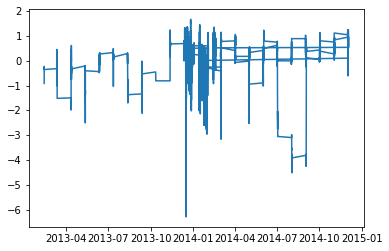

In [188]:
plt.plot(df1['zscores'])

In [197]:
(df1['zscores']<-6).sum()

2

#### From the above analysis:

From Box plot and Boxen plot: 
1. Points below the whisker can be considered as the outliers.
2. The above statment takes the fact into consideration that the values lying outside the Inter Quartile range are considered outliers.

For Zscore plot:
1. Point not following the general trend can be considered as the outliers.
2. Adding to that for a rule of thumb points having zscore below -3 and above 3 can be considered as outliers.
    - We dont have any points with zscore > 3
    - Number of points having zscores less than -3, -4 -5 and -6 are 493, 294, 12 and 2 respectively.

In [251]:
def iqr_outliers(data):
    lower_fence = data['temperature'].mean() - 3*data['temperature'].std()
    upper_fence = data['temperature'].mean() + 3*data['temperature'].std()
    print(lower_fence)
    return data[(data['temperature'] > upper_fence) | (data['temperature'] < lower_fence)]

In [253]:
iqr_outliers(df1)

46.03874866073629


,temperature,zscores
timestamp,,
2013-12-16 13:30:00,45.880652,-3.011831
2013-12-16 13:35:00,45.933487,-3.007877
2013-12-16 13:45:00,45.691805,-3.025962
2013-12-16 13:55:00,45.665022,-3.027966
2013-12-16 14:00:00,45.783002,-3.019138
...,...,...
2014-09-02 11:35:00,31.086225,-4.118916
2014-09-02 11:40:00,30.938861,-4.129943
2014-09-02 11:45:00,30.975528,-4.127199


In [255]:
#end